# **Script Statistiques Embroussaillement**

Génère un boxplot et un violinplot des données de l'embroussaillement sur la place d'arme de l'Hongrin par type de milieu


---



Nécessite un fichier geopackage .gpkg généré sur QGIS qui contient les statistiques générées avec la couche d'embroussaillement et la carte des milieux. (Outil Statistiques de zone)

Ce fichier peut être facilement généré avec le script **process_ifn_data_qgis.py**

Le script peut être trouvé dans le repo Github: [https://github.com/Aschizas/shrubvision](https://github.com/Aschizas/shrubvision)

---

Pour exécuter, appuyez sur l'icone run à gauche de chacun des blocs de code. Tous les blocs sont nécessaires à part les deux blocs après les figures qui permettent de les télécharger en PDF


In [2]:
# Install system dependencies
!apt-get update -qq
!apt-get install -y -qq gdal-bin libgdal-dev

# Set environment variables for GDAL
import os
os.environ['CPLUS_INCLUDE_PATH'] = '/usr/include/gdal'
os.environ['C_INCLUDE_PATH'] = '/usr/include/gdal'

# Install Python packages
!pip install --quiet geopandas fiona ipywidgets matplotlib seaborn


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package python3-numpy.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.21.5-1ubuntu22.04.1_amd64.deb ...
Unpacking python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Selecting previously unselected package python3-gdal.
Preparing to unpack .../python3-gdal_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking python3-gdal (3.8.4+dfsg-1~jammy0) ...
Selecting previously unselected package gdal-bin.
Preparing to unpack .../gdal-bin_3.8.4+dfsg-1~jammy0_amd64.deb ...
Unpacking gdal-bin (3.8.4+dfsg-1~jammy0) ...
Setting up python3-numpy (1:1.21.5-1ubuntu22.04.1) ...
Setting up python3-gdal (3.8.4+dfsg-1~jammy0) ...
Setting up gdal-bin (3.8.4+dfsg-1~jammy0) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━

In [4]:
from google.colab import files
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import fiona
import matplotlib.lines as mlines
import seaborn as sns # Used for both plots
import io

# --- Configuration ---
MILIEUX = [21, 221, 222, 223, 231, 41, 422, 424, 431, 432, 433, 451, 452, 453, 454]
# --- Dynamic Area Formatting Function ---
def format_area_dynamic(area_sq_m):
    SQUARE_KM_THRESHOLD = 1_000_000

    if area_sq_m >= SQUARE_KM_THRESHOLD:
        area_sq_km = area_sq_m / SQUARE_KM_THRESHOLD
        return f"{area_sq_km:.1f} km²"
    else:
        return f"{area_sq_m:.0f} m²"


In [11]:
# upload geopackage here
uploaded = files.upload()

Saving stats.gpkg to stats (1).gpkg


In [8]:


# Get the uploaded filename
gpkg_path = list(uploaded.keys())[0]
layers = fiona.listlayers(gpkg_path)
layer_name = layers[0]
print(f"\nLoading layer: {layer_name} from {gpkg_path}")
gdf = gpd.read_file(gpkg_path, layer=layer_name)
milieux_critiques = gdf[gdf["TypoCH_NUM"].isin(MILIEUX)]

# Aggregate both '_count' (total area proxy) and '_sum' (embroussaillement area)
grouped_stats = milieux_critiques.groupby("TypoCH_NUM").agg(
    Total_Count=('embrouss_count', 'sum'),
    Total_Embroussaillement=('embrouss_sum', 'sum')
).reset_index()

# Use Total_Count for sorting
sorted_milieux = grouped_stats.sort_values(by="Total_Count", ascending=False)
plot_order = sorted_milieux["TypoCH_NUM"].astype(str).tolist()

# Prepare the main plotting data (TypoCH_NUM as string for consistent plotting)
milieux_critiques["TypoCH_NUM"] = milieux_critiques["TypoCH_NUM"].astype(str)
milieux_critiques_stats = milieux_critiques


Loading layer: milieux_hongrin from stats.gpkg


/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


/tmp/ipython-input-3678092843.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


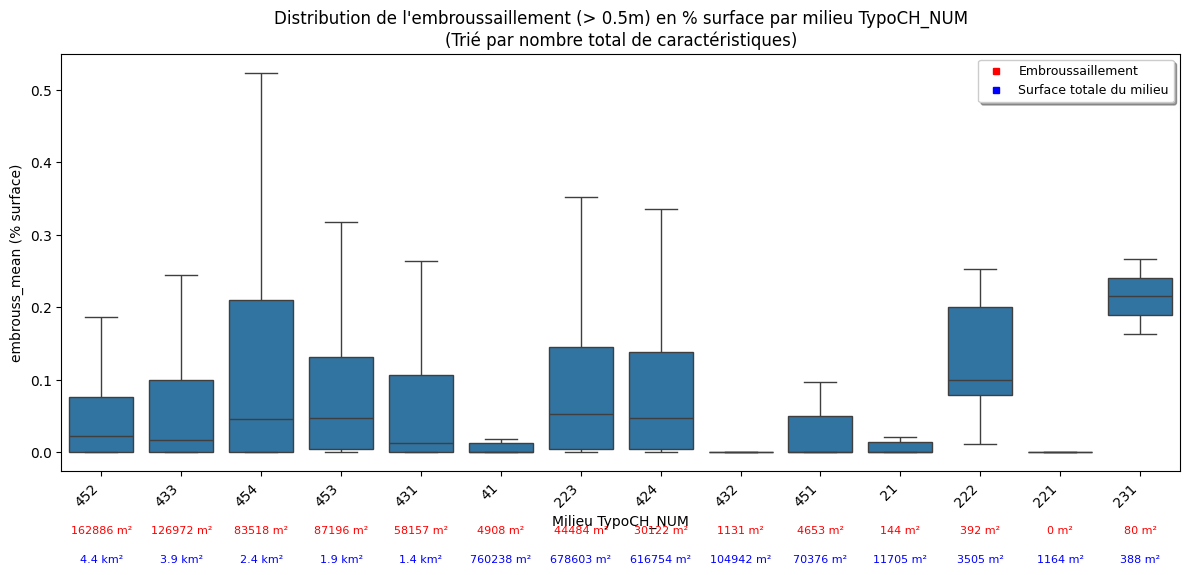

In [9]:
# ----------------------------------------------------------------------
# --- Part 2: Generate Sorted BOXPLOT (Seaborn) with Custom Labels ---
# ----------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 6))

# --- SEABORN BOXPLOT ---
sns.boxplot(
    data=milieux_critiques_stats,
    x="TypoCH_NUM",
    y="embrouss_mean",
    order=plot_order, # Use the defined sort order
    showfliers=False, # Hide outliers, matching previous plot
    ax=ax
)
# -----------------------

# Set X-axis labels (must come AFTER the seaborn plot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# --- Custom Label Positioning (Two Lines, Centered) ---
y_min = ax.get_ylim()[0]

# Define two vertical positions for the labels
# Note: These positions are relative to the final y-limits set by Seaborn
y_embroussaillement_pos = y_min - 0.15 * (ax.get_ylim()[1] - y_min)
y_total_count_pos = y_min - 0.22 * (ax.get_ylim()[1] - y_min)

for i, typo_ch_num_str in enumerate(plot_order):
    typo_ch_num = int(typo_ch_num_str)

    # Fetch both metrics
    row = sorted_milieux[sorted_milieux["TypoCH_NUM"] == typo_ch_num].iloc[0]
    total_count = row["Total_Count"]
    total_embroussaillement = row["Total_Embroussaillement"]

    # Format the values
    embroussaillement_formatted = format_area_dynamic(total_embroussaillement)
    total_count_formatted = format_area_dynamic(total_count)

    # Line 1: Embroussaillement (Above, Colored Red)
    ax.text(
        i, # Use index 'i' for x-position in Seaborn plots
        y_embroussaillement_pos,
        f"{embroussaillement_formatted}",
        ha='center',
        rotation=0,
        color='red',
        fontsize=8
    )

    # Line 2: Total Count (Below, Colored Blue)
    ax.text(
        i, # Use index 'i' for x-position in Seaborn plots
        y_total_count_pos,
        f"{total_count_formatted}",
        ha='center',
        rotation=0,
        color='blue',
        fontsize=8
    )

# --- Add Legend Box ---
red_line = mlines.Line2D([], [], color='red', marker='s', linestyle='None', markersize=5, label='Embroussaillement')
blue_line = mlines.Line2D([], [], color='blue', marker='s', linestyle='None', markersize=5, label='Surface totale du milieu')

ax.legend(handles=[red_line, blue_line],
          loc='upper right',
          fontsize=9,
          frameon=True,
          fancybox=True,
          shadow=True)

ax.set_title(f"Distribution de l'embroussaillement (> 0.5m) en % surface par milieu TypoCH_NUM\n(Trié par nombre total de caractéristiques)")
ax.set_xlabel("Milieu TypoCH_NUM")
ax.set_ylabel(f"embrouss_mean (% surface)")

plt.subplots_adjust(bottom=0.30)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("boxplot.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# you can download the figure as a pdf if you want
files.download("boxplot.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1908962377.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


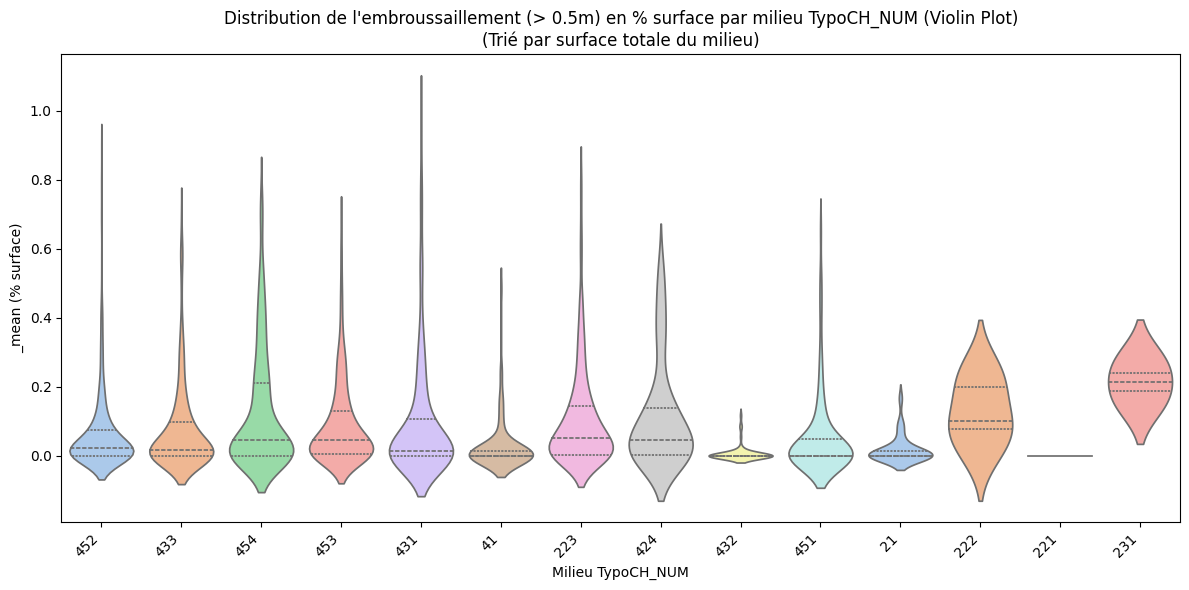

In [10]:
# ----------------------------------------------------------------------
# --- Part 3: Generate Sorted Violin Plot (Seaborn) ---
# ----------------------------------------------------------------------

plt.figure(figsize=(12, 6))

sns.violinplot(
    data=milieux_critiques_stats,
    x="TypoCH_NUM",
    y="embrouss_mean",
    order=plot_order,
    inner='quartile',
    palette="pastel"
)

plt.title(f"Distribution de l'embroussaillement (> 0.5m) en % surface par milieu TypoCH_NUM (Violin Plot)\n(Trié par surface totale du milieu)")
plt.xlabel("Milieu TypoCH_NUM")
plt.ylabel(f"_mean (% surface)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("violin_plot.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# you can download the figure as a pdf if you want
files.download("violin_plot.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>